<a href="https://colab.research.google.com/github/linhle32/Interactive-Models-with-Widget/blob/main/regression_on_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model development

This is a notebook template for you to perform a regression project on data that has numeric targets. For the most parts, you do not have to write more codes, but only edit the following
- Path to input data
- List of symmetric features, skewed features, and categorical features
- Path to save processing pipeline
- Path to save the trained neural network

The model selection will be automated, with the best one being saved for deployment.

### Load data

The assumption is that you have had created a Google Drive folder for the project, and have uploaded the data as a `csv` file. Modify the `data_path` to the correct path to your data set. In my example, I use a small dataset from https://www.kaggle.com/datasets/thedevastator/prediction-of-insurance-charges-using-age-gender

Use the data view to determine which columns are numeric, and which are categorical.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
data_path = 'insurance.csv'

In [2]:
#load data with pandas
import pandas as pd
data = pd.read_csv(data_path)

#train test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.2)

train_data.head(3)

,index,age,sex,bmi,children,smoker,region,charges
295,295,18,male,22.99,0,no,northeast,1704.5681
1171,1171,43,female,26.70,2,yes,southwest,22478.6000
1334,1334,18,female,31.92,0,no,northeast,2205.9808


### Data Visualization

Base on the table displayed above, fill the lists `num_cols` and `cat_cols` with the correct numeric features and categorical features. We do not have to separate the features and target at this point.
- `num_cols` includes all numeric features and the target
- `cat_cols` includes all categorical features

**Feature names should be string**

In [ ]:
num_cols = ['age','bmi','children','charges']
cat_cols = ['sex','smoker','region']

### Histograms for Numeric Columns

Note down which columns are symmetrical, and which are skewed

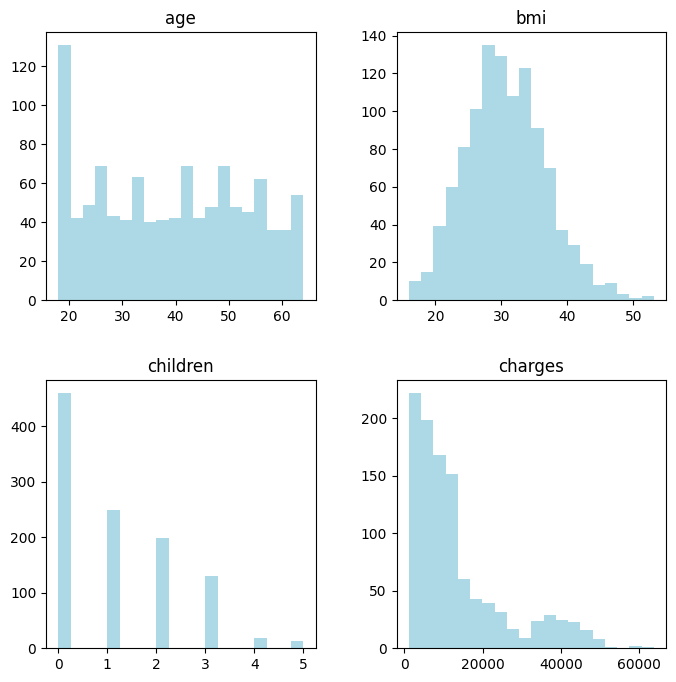

In [ ]:
import matplotlib.pyplot as plt
train_data[num_cols].hist(bins=20, figsize=(8,8), color='lightblue', grid=False)
plt.show()

### Bar charts for Categorical Columns

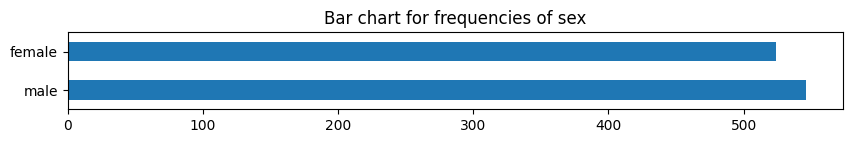

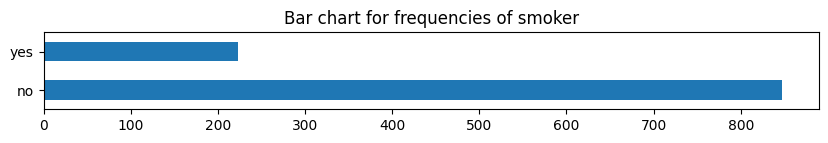

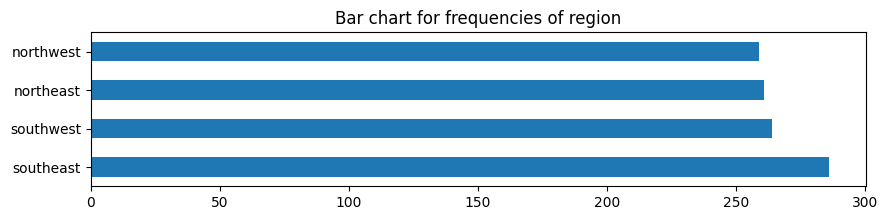

In [ ]:
for col in cat_cols:
    freq_table = train_data[col].value_counts()
    plt.figure(figsize = (10,len(freq_table)*0.5)) #a bit formatting so that chart look better
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

### Data Pipeline

Now, fill in the `num_cols`, `log_cols`, `cat_cols`, and `target` with the correct columns.
- `num_cols` includes all numeric features that are symmetric
- `log_cols` includes all numeric features that are skewed
- `cat_cols` includes all categorical features
- `target` is the name of the target column

**All names should be strings**

The processing pipeline that we will build next is as follows
- Numeric columns with symmetric (or close to symmetric) histograms get imputed then standardized
- Numeric columns with skewed histograms get imputed, log transformed, then standardized
- Categorical columns get one hot encoded with max categories of 5. Meaning that only the top 5 most frequent values in each column are encoded, the rest collapses into `other`

This is just a basic pipeline to handle common issues in data. For data with more specific problems like coded values or incorrect values, you may want to manually define other `FunctionTransformer` to address them.

In [3]:
num_cols = ['age','bmi','children']  #this list is for symmetric numeric columns
log_cols = []  #this list is for skewed numeric columns
cat_cols = ['sex','smoker','region']  #this list for the class columns
target = 'charges'    #this is the name of the target

In [4]:
#processing pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config

set_config(transform_output="pandas")

import numpy as np

num_pipeline = Pipeline([                           #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),   #this step will impute missing values using column medians
    ('standardize', StandardScaler())               #this step will scale all numeric columns
])

def log_transform(x):
  return np.log(x + 0.01)

log_pipeline = Pipeline([                                              #now we need a small pipeline for numeric columns since it has two steps
    ('impute', SimpleImputer(strategy='median')),                      #this step will impute missing values using column medians
    ('log transform', FunctionTransformer(log_transform)),  #this include a log transformation into the pipeline
    ('standardize', StandardScaler())                                  #this step will scale all numeric columns
])

processing_pipeline = ColumnTransformer([                                                      #this transformer merges the processed numeric columns and class columns
    ('numeric', num_pipeline, num_cols),                                                       #numeric columns
    ('log', log_pipeline, log_cols),                                                           #log columns
    ('class', OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False), cat_cols) #encoder to transform class columns to numeric, this will automatically handle missing data
  ])

processing_pipeline.fit(train_data)                            #train the pipeline

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['age', 'bmi', 'children']),
                                ('log',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('log transform',
                                                  FunctionTransformer(func=<function log_transform at 0x7baa04f73a30>)),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 []),
                                ('class',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               max_categories=5,
                                               sparse_output=False),
                                 ['sex', 'smoker', 'region'])])

### Save the processing pipeline
Now let us save the processing pipeline for uses later on.

In [5]:
pipeline_save_path = 'process_pipeline.pk'

In [6]:
import joblib

joblib.dump(processing_pipeline, pipeline_save_path)

['process_pipeline.pk']

### Model Training

We will use TensorFlow. First, we initilize some parameters. These can be played with for better training/validation error.

In [13]:
num_layers = 5
num_iters = 1000
learning_rate = 0.001

In [ ]:
trainX = processing_pipeline.transform(train_data)             #generate the training features
trainY = train_data[target].values                             #generate the training target
testX = processing_pipeline.transform(test_data)               #generate the testing features
testY = test_data[target].values                               #generate the testing features

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input

neural_net = Sequential()
neural_net.add(Input(shape=trainX.shape[1]))
for _ in range(num_layers):
  neural_net.add(Dense(trainX.shape[1], activation='relu'))
neural_net.add(Dense(1, activation='linear'))

neural_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mean_squared_error')
neural_net.fit(trainX, trainY, epochs=num_iters, batch_size=int(trainX.shape[0]//10), validation_split=0.2)

### Evaluate the model

The default evaluation metric is Mean Squared Error (which is also the loss we used previously when training)

In [16]:
neural_net.evaluate(testX, testY)

9/9 [==============================] - 0s 8ms/step - loss: 19786808.0000


19786808.0

### Save the model

When the testing error is acceptable, we can save the trained model

In [17]:
model_save_path = 'reg_neural_net_model'

neural_net.save(model_save_path)

# Simple Interactive Application

We do usually need to host our model, for examples, in AWS or MS Azure, and build a complete GUI application to complete the project. However, those services could be costly. Instead, we can utilize the `ipywidgets` library which provides a very easy-to-use interactive form framework to build a small application for our trained model.

Of course, the application will not able to stay constantly online, as well as is limited in multiple aspect. However, it is still useful for personal use, or just to play and experience with your model.

If start in a different session, you will need to reload the necessary libraries and load the model saved in the first part of this notebook. We also need to load the training data to have a reference to build our application. Finally, change `target` to the correct column in the data.


In [19]:
data_path = 'insurance.csv'
pipeline_save_path = 'process_pipeline.pk'
model_save_path = 'reg_neural_net_model'

In [18]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from keras.models import load_model
import joblib
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Markdown
from sklearn import set_config
set_config(transform_output="pandas")

def log_transform(x):
    return np.log(x)

processing_pipeline = joblib.load(pipeline_save_path)
neural_net = load_model(model_save_path)
data = pd.read_csv(data_path)

Mounted at /content/drive


Next, we automate the generation of the input form with two loops
- The first loop to create a number slider for the numeric columns.
  - I will use the column min and max in the training data as the range of the slider
  - The start value of the slider is the column mean
  - The step will be `0.1` if the column is float, and `1` if it is integer
- The second loop to create a drop down list for each categorical columns.

Only columns that are used in model will have their input fields populated.

In [20]:
used_cols_cat = list(processing_pipeline.named_transformers_['class'].feature_names_in_)
used_cols_num = list(processing_pipeline.named_transformers_['numeric'].feature_names_in_)
try:
  used_cols_num += list(processing_pipeline.named_transformers_['log'].feature_names_in_)
except:
  pass

import ipywidgets as widgets
from IPython.display import display, Markdown

form = {}
for col in used_cols_num:
  if data[col].dtype == 'int':
    step = 1
  else:
    step = 0.1
  form[col] = widgets.FloatSlider(
    value=data[col].mean(), min=data[col].min(), max=data[col].max(), step=step,
    description=col, continuous_update=True, readout=True,
  )
  display(form[col])

for col in used_cols_cat:
  form[col] = widgets.Dropdown(
      options=data[col].unique(), value=data[col].unique()[0],
      description=col, continuous_update=True, readout=True
  )
  display(form[col])

button = widgets.Button(description="Predict")
output = widgets.Output()

display(button, output)

@output.capture()
def on_button_clicked(b):
  data_to_pred = {}
  for col in form:
    data_to_pred[col] = [form[col].value]
  data_to_pred = processing_pipeline.transform(pd.DataFrame(data_to_pred))
  prediction = neural_net.predict(data_to_pred, verbose=False)
  output.clear_output()
  display(Markdown('## Prediction: ' + str(np.round(prediction,2))))

button.on_click(on_button_clicked)

FloatSlider(value=39.20702541106129, description='age', max=64.0, min=18.0, step=1.0)

FloatSlider(value=30.66339686098655, description='bmi', max=53.13, min=15.96)

FloatSlider(value=1.0949177877429, description='children', max=5.0, step=1.0)

Dropdown(description='sex', options=('female', 'male'), value='female')

Dropdown(description='smoker', options=('yes', 'no'), value='yes')

Dropdown(description='region', options=('southwest', 'southeast', 'northwest', 'northeast'), value='southwest'…

Button(description='Predict', style=ButtonStyle())

Output()